In [277]:
from IPython.display import display, HTML
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("darkgrid")
%matplotlib inline
pd.set_option('display.notebook_repr_html', True)

In [284]:
#fixed metric scores for all 7 this way. made new _correct.pkl files.

with open('fixed_kahunas/BernNBcm.pkl', 'r') as pklfile:
    readin = pickle.load(pklfile)
actual, predicted = readin

labelbin = LabelBinarizer()
labelbin.fit([0,1,2])

actual = labelbin.inverse_transform(actual)
predicted = labelbin.inverse_transform(predicted)

scores = [recall_score, precision_score, accuracy_score, f1_score]
masterlist = []

for score in scores:
    if score == accuracy_score:
        masterlist.append({score:score(actual, predicted)})
    else:
        masterlist.append({score:score(actual, predicted, average=None)})
with open("BernNBscores_correct.pkl", "w") as pklfile:
    pickle.dump(masterlist, pklfile)

print masterlist
print 'Done here.(5/5)'

[{<function recall_score at 0x10771aed8>: array([ 0.999954  ,  0.00123331,  0.        ])}, {<function precision_score at 0x10771ae60>: array([ 0.95999706,  0.35416667,  0.        ])}, {<function accuracy_score at 0x10771aa28>: 0.95994859429237656}, {<function f1_score at 0x10771ac80>: array([ 0.97956823,  0.00245807,  0.        ])}]
Done here.(5/5)


In [327]:
#make a dummy baseline model that predicts all majority class (Class 0).

#read in cm file that'll have y_test and test_pred, and then change all the test_preds to value 0s. 
#then get metrics, and pickle. get ROC params, PR params, and pickle.

with open("fixed_kahunas/BernNBcm.pkl", "r") as pkf:
    d = pickle.load(pkf)
actual, predicted = d

In [328]:
#converting predicted to all class 0 values.[1,0,0]
predicted = np.array(map(lambda x:[1, 0, 0], predicted))

In [335]:
cmlist = [actual, predicted]
with open("Dummycm.pkl","w") as pk:
    pickle.dump(cmlist, pk)
print 'Done re-pickling.'

Done re-pickling.


In [329]:
#getting scores for the dummy prediction.
labelbin = LabelBinarizer()
labelbin.fit([0,1,2])

actual2 = labelbin.inverse_transform(actual)
predicted2 = labelbin.inverse_transform(predicted)

scores = [recall_score, precision_score, accuracy_score, f1_score]
masterlist = []

for score in scores:
    if score == accuracy_score:
        masterlist.append({score:score(actual2, predicted2)})
    else:
        masterlist.append({score:score(actual2, predicted2, average=None)})
with open("Dummyscores_correct.pkl", "w") as pklfile:
    pickle.dump(masterlist, pklfile)

print masterlist
print 'Done here.(5/5)'

#actual2 is non-binarized
#acual is still binarized, ready for ROC PR param step next.

[{<function recall_score at 0x10771aed8>: array([ 1.,  0.,  0.])}, {<function precision_score at 0x10771ae60>: array([ 0.95996773,  0.        ,  0.        ])}, {<function accuracy_score at 0x10771aa28>: 0.95996773158330173}, {<function f1_score at 0x10771ac80>: array([ 0.97957504,  0.        ,  0.        ])}]
Done here.(5/5)


In [330]:
actual[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [331]:
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall = dict()
average_precision = dict()

n_classes = [0,1,2]

for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(actual[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(actual[:, i], predicted[:, i])
    average_precision[i] = average_precision_score(actual[:, i], predicted[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(actual.ravel(), predicted.ravel())
average_precision["micro"] = average_precision_score(actual, predicted, average="micro")

roc_list = [fpr, tpr, roc_auc, precision, recall, average_precision]

with open("Dummy_ROCAUC.pkl", "w") as pfile:
    pickle.dump(roc_list, pfile)

print 'done with roc_auc stuff too. finished.'

done with roc_auc stuff too. finished.


In [262]:
def class_scores(dict_read_in, algo):
    scores = ['Recall score', 'Precision Score', 'F1 score']
    
    a_score = dict_read_in[2].items()[0][1]
    newlist = list(dict_read_in[0:2])+list(dict_read_in[3:])
    
    recall_list = []
    prec_list = []
    f1_list = []

    lists = [recall_list, prec_list, f1_list]

    for i in range(len(lists)):
        lists[i].extend(list(newlist[i].values())[0])
        
    df = np.round(pd.DataFrame(data = [recall_list, prec_list, f1_list]),4)
    df.columns = ["Class 0", "Class 1", "Class 2"]
    df.index = ['Recall score', 'Precision Score', 'F1 score']
    
    print algo
    print "Accuracy Score is:", format(a_score, '0.4f')
    return display(df)
    print '\n'*3

In [263]:
class_scores(a, 'Random Forest')

Random Forest
Accuracy Score is: 0.8554


,Class 0,Class 1,Class 2
Recall score,0.9152,0.5316,0.4682
Precision Score,0.9823,0.1564,0.1550
F1 score,0.9476,0.2417,0.2329


In [139]:
scores = ['Recall score', 'Precision Score', 'Accuracy score', 'F1 score']

def printscores(werk):
    for i, score in enumerate(scores):
        for (k,v) in werk[i].items():
            print score + ":", v
    print '\n'
            
def plotROC(fpr, tpr, roc_auc, Thename):
    plt.figure(figsize = (6,4))
    plt.plot(fpr[0], tpr[0], color = "skyblue", linewidth = 2, label='Class 0 ROC curve (AUC = %0.4f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color = 'magenta', linewidth = 2, label='Class 1 ROC curve (AUC = %0.4f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color = 'lightgreen', linewidth = 2, label='Class 2 ROC curve (AUC = %0.4f)' % roc_auc[2])
    plt.title(Thename, fontsize = 15, y=1.02)
    plt.xlabel("False Positive Rate", fontsize = 10)
    plt.ylabel("True\nPositive\nRate", fontsize = 10, labelpad = 20).set_rotation(0)
    plt.legend(loc="lower right")
    
with open("kahuna_pickles/KahunaLog.pkl", "r") as somethin:
    a = pickle.load(somethin)
# with open('kahuna_pickles/KahunaLog_ROCAUC.pkl', 'r') as plzwork: 
#     b = pickle.load(plzwork)

Basecase (All Class 0 Prediction)
Accuracy Score is: 0.9600


,Class 0,Class 1,Class 2
Recall score,1.0000,0,0
Precision Score,0.9600,0,0
F1 score,0.9796,0,0


Decision Tree
Accuracy Score is: 0.9506


,Class 0,Class 1,Class 2
Recall score,0.9837,0.1548,0.1597
Precision Score,0.9664,0.2733,0.2796
F1 score,0.9750,0.1977,0.2033


Random Forest
Accuracy Score is: 0.9588


,Class 0,Class 1,Class 2
Recall score,0.9923,0.1500,0.1565
Precision Score,0.9661,0.4517,0.4312
F1 score,0.9790,0.2252,0.2296


Logistic Regression
Accuracy Score is: 0.7733


,Class 0,Class 1,Class 2
Recall score,0.7869,0.8419,0.0433
Precision Score,0.9926,0.0783,0.0411
F1 score,0.8779,0.1432,0.0422


Bagging Decision Tree
Accuracy Score is: 0.8728


,Class 0,Class 1,Class 2
Recall score,0.8920,0.6116,0.2083
Precision Score,0.9853,0.1232,0.1362
F1 score,0.9364,0.2051,0.1647


Bagging Random Forest
Accuracy Score is: 0.9250


,Class 0,Class 1,Class 2
Recall score,0.9489,0.4369,0.2660
Precision Score,0.9779,0.1966,0.2240
F1 score,0.9632,0.2712,0.2432


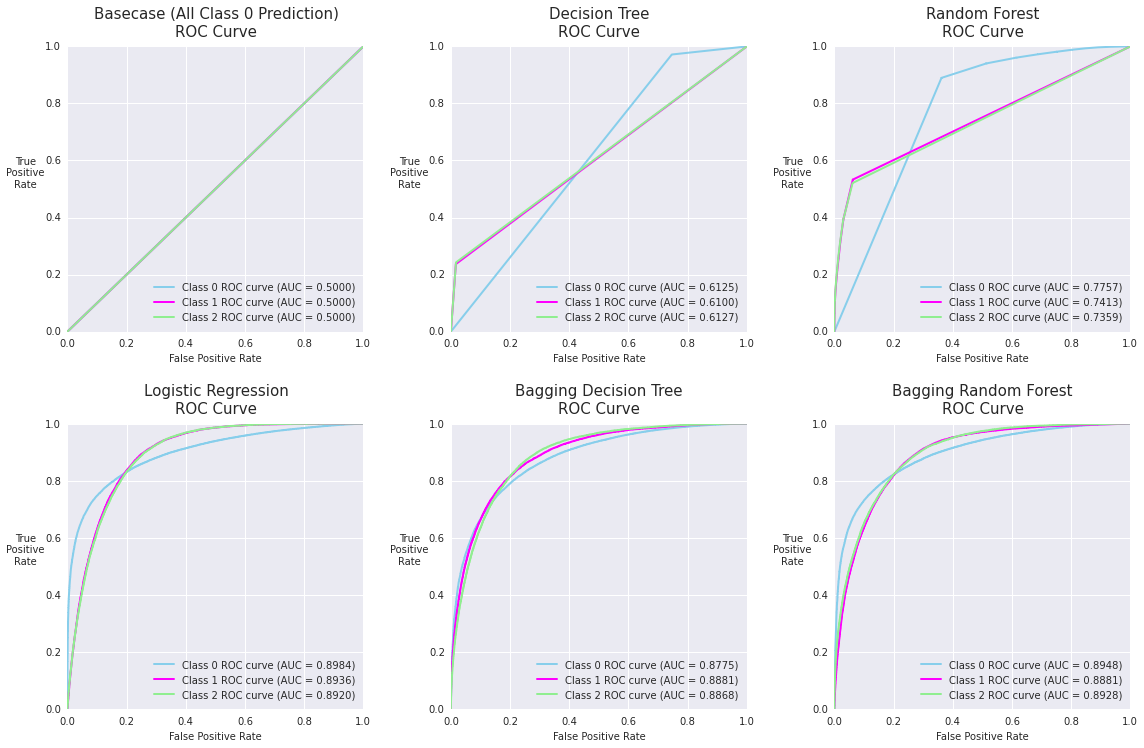

In [334]:
classifiers = ['Basecase (All Class 0 Prediction)',  'Decision Tree', 'Random Forest', 
               'Logistic Regression', 'Bagging Decision Tree', 'Bagging Random Forest']

scorefiles = ['fixed_kahunas/Dummyscores_correct.pkl', 'fixed_kahunas/DTscores_correct.pkl','fixed_kahunas/RFscores_correct.pkl',
              'fixed_kahunas/Logscores_correct.pkl', 'fixed_kahunas/BaggingDTscores_correct.pkl', 'fixed_kahunas/BaggingRFscores_correct.pkl']

ROCfiles = ['kahuna_pickles/Dummy_ROCAUC.pkl','kahuna_pickles/KahunaDT_ROCAUC2.pkl','kahuna_pickles/KahunaRF_ROCAUC2.pkl',
            'kahuna_pickles/KahunaLog_ROCAUC2.pkl','kahuna_pickles/KahunaBagging_ROCAUC2.pkl','kahuna_pickles/KahunaBaggingRF_ROCAUC2.pkl']

plt.figure(figsize = (16,10.5))

for i, algo in enumerate(classifiers):
    ax = plt.subplot(2,3,i+1)
    
    with open(scorefiles[i], 'r') as somethin:
        a = pickle.load(somethin)
    with open(ROCfiles[i], 'r') as plzwork: 
        b = pickle.load(plzwork)
    fpr, tpr, roc_auc, precision, recall, average_precision = b
    
    class_scores(a, algo), '\n'*3
    
    ax.plot(fpr[0], tpr[0], color = "skyblue", linewidth = 2, label='Class 0 ROC curve (AUC = %0.4f)' % roc_auc[0])
    ax.plot(fpr[1], tpr[1], color = 'magenta', linewidth = 2, label='Class 1 ROC curve (AUC = %0.4f)' % roc_auc[1])
    ax.plot(fpr[2], tpr[2], color = 'lightgreen', linewidth = 2, label='Class 2 ROC curve (AUC = %0.4f)' % roc_auc[2])
    plt.title('{0}\nROC Curve'.format(algo), fontsize = 15, y=1.02)
    plt.xlabel("False Positive Rate", fontsize = 10)
    plt.ylabel("True\nPositive\nRate", fontsize = 10, labelpad = 20).set_rotation(0)
    plt.legend(loc="lower right")
    plt.tight_layout(w_pad = 2, h_pad = 2)

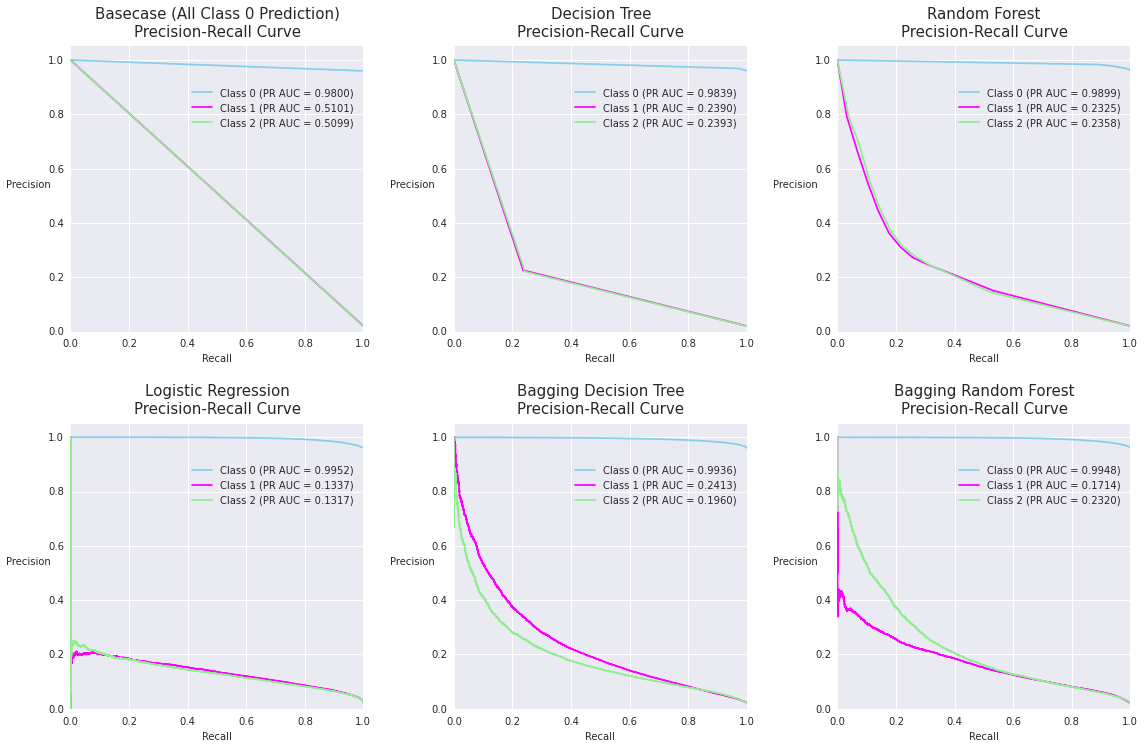

In [339]:
plt.figure(figsize = (16,10.5))

for i, algo in enumerate(classifiers):
    ax = plt.subplot(2,3,i+1)

    with open(ROCfiles[i], 'r') as plzwork: 
        b = pickle.load(plzwork)
    fpr, tpr, roc_auc, precision, recall, average_precision = b
    
    ax.plot(recall[0], precision[0], color = 'skyblue',
        label='Class {0} (PR AUC = {1:0.4f})'
                   ''.format(0, average_precision[0]))
    ax.plot(recall[1], precision[1], color = 'magenta',
        label='Class {0} (PR AUC = {1:0.4f})'
                   ''.format(1, average_precision[1]))
    ax.plot(recall[2], precision[2], color = 'lightgreen',
        label='Class {0} (PR AUC = {1:0.4f})'
                   ''.format(2, average_precision[2]))
    plt.xlabel('Recall', fontsize = 10)
    plt.ylabel('Precision', labelpad = 20, fontsize = 10).set_rotation(0)
    plt.title('{0}\nPrecision-Recall Curve'.format(algo), fontsize = 15, y = 1.02)
    plt.ylim([0.0, 1.05])
    plt.legend(loc = (0.4,0.7))
    plt.tight_layout(w_pad = 2, h_pad = 2)

In [287]:
def switchvals(arr, val1, val2):
    mask1 = arr == val1
    mask2 = arr == val2
    arr[mask1] = val2
    arr[mask2] = val1
    return arr

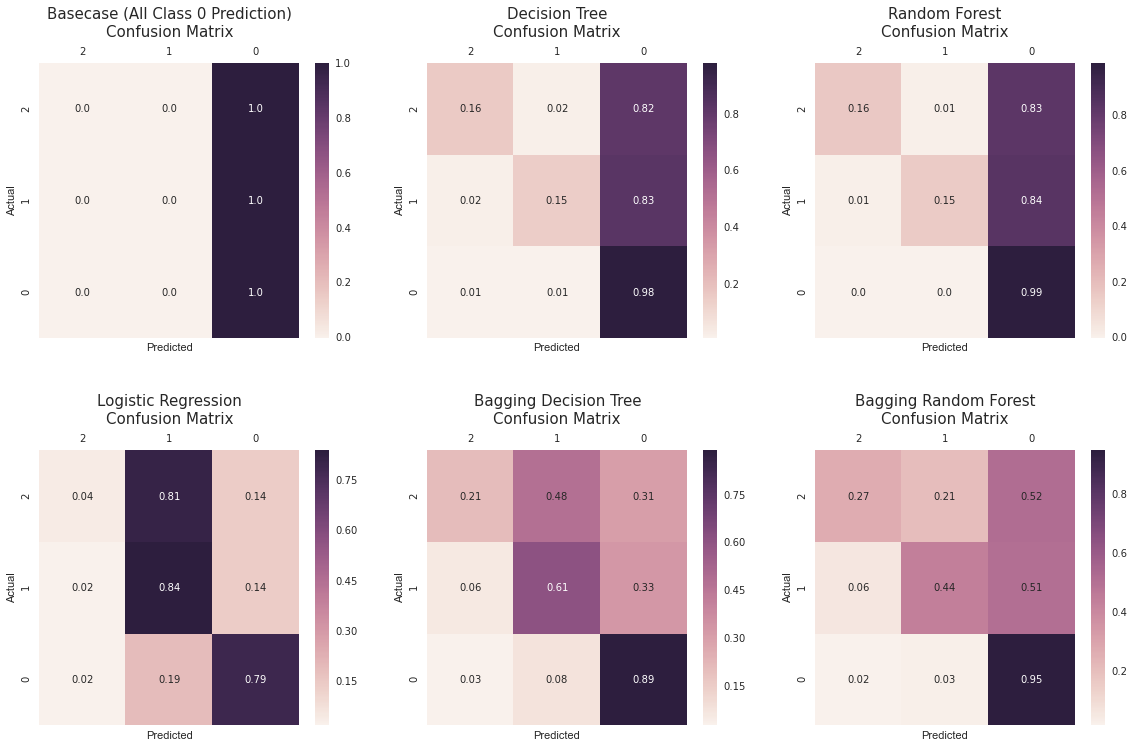

In [350]:
classifiers = ['Basecase (All Class 0 Prediction)',  'Decision Tree', 'Random Forest', 
               'Logistic Regression', 'Bagging Decision Tree', 'Bagging Random Forest']

cmfiles = ['fixed_kahunas/Dummycm.pkl', 'fixed_kahunas/DTcm.pkl', 'fixed_kahunas/RFcm.pkl',
          'fixed_kahunas/Logcm.pkl', 'fixed_kahunas/BaggingDTcm.pkl', 'fixed_kahunas/BaggingRFcm.pkl']

plt.figure(figsize=(16, 10.5))

for i, algo in enumerate(classifiers):
    ax = plt.subplot(2,3,i+1)
    
    with open(cmfiles[i], 'r') as pklfile:
        readin = pickle.load(pklfile)
    actual, predicted = readin

    labelbin = LabelBinarizer()
    labelbin.fit([0,1,2])

    actual = labelbin.inverse_transform(actual)
    predicted = labelbin.inverse_transform(predicted)

    actual = switchvals(actual, 0, 2)
    predicted = switchvals(predicted, 0, 2)

    cm = confusion_matrix(actual, predicted)
    cm_normalized = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
    
    cm_df = pd.DataFrame(cm_normalized)
    cm_df.index.names = ['Actual']
    cm_df.columns.names = ['Predicted']
    
    sns.heatmap(cm_df, annot=True,  fmt='', xticklabels=[2,1,0], yticklabels=[2,1,0])
    ax.tick_params(labelbottom='off',labeltop='on')
    plt.title('{0}\nConfusion Matrix'.format(algo), fontsize = 15, y= 1.08)
    plt.tight_layout(w_pad = 4, h_pad = 4)

In [ ]:
smallerkahuna = bigkahuna[['station_name', 'dayofwk', 'hour', 'summary', 'temperature', 'flowdiff']]